<a href="https://colab.research.google.com/github/ZHOU-py/Tensorflow-federated-learning/blob/main/Federated_Learning_for_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@test {"skip": true}
!pip install --quiet --upgrade tensorflow_federated_nightly
!pip install --quiet --upgrade nest_asyncio

import nest_asyncio
nest_asyncio.apply()

%reload_ext tensorboard

     |████████████████████████████████| 522kB 2.8MB/s 
     |████████████████████████████████| 112kB 15.3MB/s 
     |████████████████████████████████| 174kB 12.4MB/s 
     |████████████████████████████████| 1.1MB 12.9MB/s 
     |████████████████████████████████| 3.0MB 15.7MB/s 
     |████████████████████████████████| 394.2MB 36kB/s 
     |████████████████████████████████| 153kB 50.3MB/s 
     |████████████████████████████████| 10.6MB 44.7MB/s 
     |████████████████████████████████| 471kB 41.7MB/s 
     |████████████████████████████████| 1.3MB 43.9MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: tf-nightly 2.5.0.dev20201024 has requirement absl-py~=0.10, but you'll have absl-py 0.9.0 which is incompatible.
ERROR: tf-nightly 2.5.0.dev20201024 has requirement grpcio~=1.32.0, but you'll have grpcio 1.29.0 which is incompatible.
ERROR: tf-nightly 2.5.0.dev20201024 has requirement numpy~=1.19.2, but you'll have numpy 1

#### Federated Learning with TensorFlow: Load Decentralized MNIST Dataset

In [2]:
# Federated_learning_for_image_classificaiton
# Samplified, added an example of random client sampling

import collections
import numpy as np
np.random.seed(0)

import tensorflow as tf
from tensorflow.python.keras.optimizer_v2 import gradient_descent
import tensorflow_federated as tff
from random import choices

NUM_EPOCHS = 5
BATCH_SIZE = 20
SHUFFLE_BUFFER = 500
NUM_CLIENTS = 3

tf.compat.v1.enable_v2_behavior()
# loading simulation data
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()
def preprocess(dataset):
  def element_fn(element):
    return collections.OrderedDict([
                                    ('x',tf.reshape(element['pixels'],[-1])),
                                    ('y',tf.reshape(element['label'],[1])),
                                    ])
    
  return dataset.repeat(NUM_EPOCHS).map(element_fn).shuffle(
      SHUFFLE_BUFFER).batch(BATCH_SIZE)


def make_federated_data(client_data,client_ids):
  return [preprocess(client_data.create_tf_dataset_for_client(x))
          for x in client_ids]

sample_clients = emnist_train.client_ids[0:NUM_CLIENTS]
federated_train_data = make_federated_data(emnist_train, sample_clients)

sample_clients_test = emnist_test.client_ids[0:NUM_CLIENTS]
federated_test_data = make_federated_data(emnist_test, sample_clients_test)

# This is only needed to create the "federated" ver of the model
sample_batch = iter(federated_train_data[0]).next()
sample_batch = collections.OrderedDict([
                                        ('x',sample_batch['x'].numpy()),
                                        ('y',sample_batch['y'].numpy()),
])


/usr/local/lib/python3.6/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:43: UserWarning: You are currently using a nightly version of TensorFlow (2.5.0-dev20201024). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  UserWarning,


#### Prepare Dataset

In [7]:
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

In [8]:
len(emnist_train.client_ids)

3383

In [9]:
emnist_train.element_type_structure

OrderedDict([('label', TensorSpec(shape=(), dtype=tf.int32, name=None)),
             ('pixels',
              TensorSpec(shape=(28, 28), dtype=tf.float32, name=None))])

In [10]:
example_dataset = emnist_train.create_tf_dataset_for_client(
    emnist_train.client_ids[0])

example_element = next(iter(example_dataset))
example_element['label'].numpy()

5

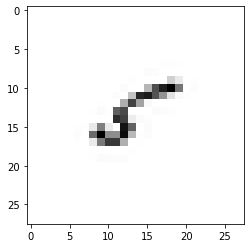

In [11]:
from matplotlib import pyplot as plt
plt.imshow(example_element['pixels'].numpy(), cmap='gray', aspect='equal')
plt.grid(False)
_ = plt.show()

#### Exploring heterogeneity in federated data

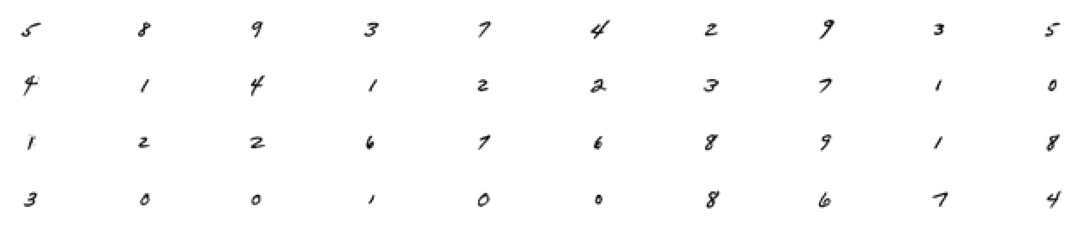

In [12]:
## Example MNIST digits for one client
figure = plt.figure(figsize=(20, 4))
j = 0

for example in example_dataset.take(40):
  plt.subplot(4, 10, j+1)
  plt.imshow(example['pixels'].numpy(), cmap='gray', aspect='equal')
  plt.axis('off')
  j += 1

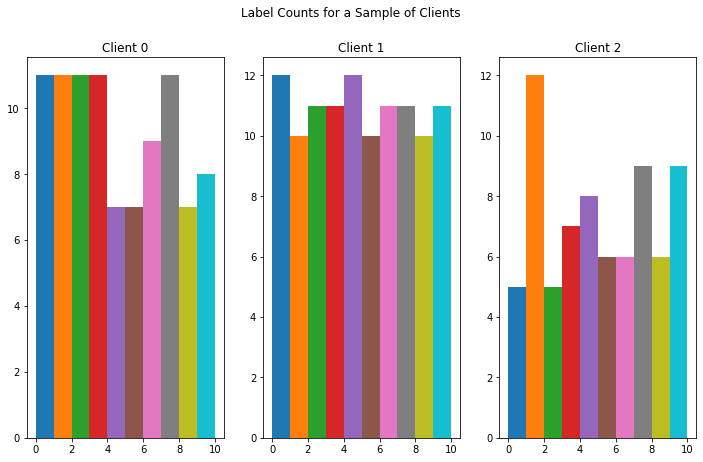

In [14]:
# Number of examples per layer for a sample of clients
f = plt.figure(figsize=(12,7))
f.suptitle('Label Counts for a Sample of Clients')
for i in range(3):
  client_dataset = emnist_train.create_tf_dataset_for_client(
      emnist_train.client_ids[i])
  plot_data = collections.defaultdict(list)
  for example in client_dataset:
    # Append counts individually per label to make plots
    # more colorful instead of one color per plot.
    label = example['label'].numpy()
    plot_data[label].append(label)
  plt.subplot(1,3,i+1)
  plt.title('Client {}'.format(i))
  for j in range(10):
    plt.hist(      
            plot_data[j],
            density=False,
            bins =[0,1,2,3,4,5,6,7,8,9,10]
        )
    

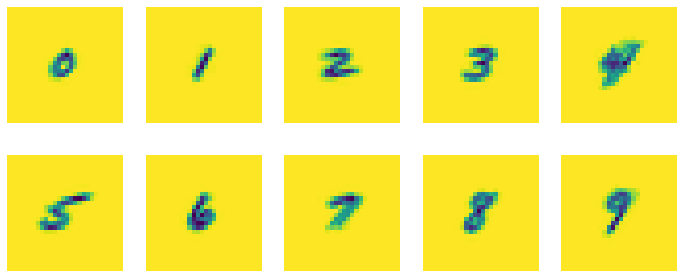

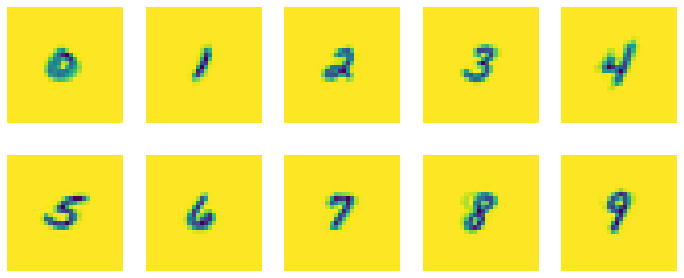

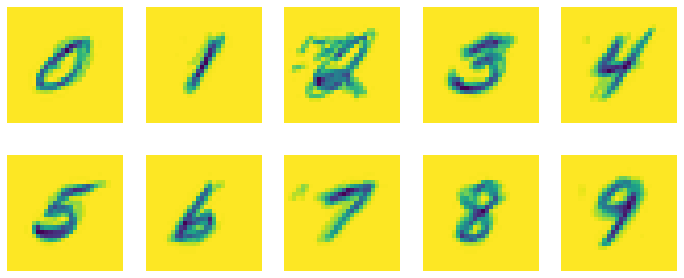

In [18]:
# Each client has different mean images, meaning each client will be nudging
# the model in their own directions locally.

for i in range(3):
  client_dataset = emnist_train.create_tf_dataset_for_client(
      emnist_train.client_ids[i])
  plot_data = collections.defaultdict(list)
  for example in client_dataset:
    plot_data[example['label'].numpy()].append(example['pixels'].numpy())
  f = plt.figure(i, figsize=(12,5))
  
  for j in range(10):
    mean_img = np.mean(plot_data[j],0)
    plt.subplot(2, 5, j+1)
    plt.imshow(mean_img.reshape((28,28)))
    plt.axis('off')

#### Preprocessing the input data
1. flatten `28x28` image into `784`-element arrays
2. shuffle the individual examples
3. organize the examples into batches and rename the features from `pixels` and `label` to `x` and `y` for use with Keras.
4. `repeat` over the data set to run several epochs.

In [ ]:
NUM_CLIENTS = 10
NUM_EPOCHS = 5
BATCH_SIZE = 20
SHUFFLE_BUFFER = 100
PREFETCH_BUFFER = 10

def preprocess(dataset):

  def batch_format_fn(element):
    """Flatten a batch `pixels` and return the features as an `OrderedDict`."""
    return collections.OrderedDict(
        x=tf.reshape(element['pixels'], [-1, 784]),
        y=tf.reshape(element['label'], [-1, 1]))

  return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(
      BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)

In [19]:
preprocessed_example_dataset = preprocess(example_dataset)

sample_batch = tf.nest.map_structure(lambda x: x.numpy(),
                                     next(iter(preprocessed_example_dataset)))

sample_batch

OrderedDict([('x', array([[1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     ...,
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)),
             ('y', array([[0],
                     [4],
                     [0],
                     [2],
                     [8],
                     [1],
                     [9],
                     [6],
                     [6],
                     [0],
                     [3],
                     [6],
                     [9],
                     [6],
                     [6],
                     [0],
                     [2],
                     [8],
                     [1],
                     [9]], dtype=int32))])

Construct a list of datasets from the given set of users as an input to a round of training or evaluation.

In [ ]:
def make_federated_data(client_data, client_ids):
  return [
          preprocess(client_data.create_tf_dataset_for_client(x))
          for x in client_ids
  ]

In [ ]:
sample_clients = emnist_train.client_ids[0:NUM_CLIENTS]

federated_train_data = make_federated_data(emnist_train, sample_clients)

print('Number of client datasets: {l}'.format(l=len(federated_train_data)))
print('First dataset: {d}'.format(d=federated_train_data[0]))

#### Creating a model with Keras

In [ ]:
def create_keras_model():
  return tf.keras.models.Seauential([
                                     tf.keras.layers.Input(shape=(784,)),
                                     tf.keras.layers.Dense(10, kernel_intializer='zeros'),
                                     tf.keras.layers.Softmax()
  ])

In [ ]:
def model_fn():
  keras_model = create_keras_model(
      keras_model,
      input_spec = preprocessed_example_dataset.element_spec,
      loss = tf.keras.losses.SparseCategorialCrossentropy(),
      metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
  )

#### Training the model on federated data

_client_optimizer_ is only used to compute local model updates on each client.
_server_optimizer_ applies the averaged update to the global model at the server.

In [ ]:
iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn = lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
    server_optimizer_fn = lambda: tf.keras.optimizers.SGD(learning_rate=1.0)
)